In [1]:
import evaluate
import datasets
from datasets import load_dataset, Dataset, Features, Sequence, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json
import summarization
from hierarchy_node import HierarchyNode
from tree_encoding import TreeEncoding
import numpy as np
from compare_summary_general import mean_pooling
import gudhi 
import sklearn
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


/Users/martincarrasco/miniconda3/envs/tml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

rouge = evaluate.load('rouge')
cnn_data = load_dataset("cnn_dailymail", '2.0.0')


In [3]:
history_1 = cnn_data['validation'].filter(lambda x: 'A British dance' in x['article'])
history_2 = cnn_data['validation'].filter(lambda x: 'A Minneapolis weatherman' in x['article'])
history_3 = cnn_data['validation'].filter(lambda x: 'A self-driving car is gearing up' in x['article'])


with open('input/history_1.txt', 'w') as f:
    f.write(history_1[0]['article'])

with open('input/history_2.txt', 'w') as f:
    f.write(history_2[0]['article'])

with open('input/history_3.txt', 'w') as f:
    f.write(history_3[0]['article'])

In [4]:
history_1

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1
})

Now the EDU generation needs to be performed

In [4]:
with open('input/history_1_edus.txt', 'r') as f:
   lines = [l.strip() for l in f.readlines()]

with open('input/history_2_edus.txt', 'r') as f:
   lines_2 = [l.strip() for l in f.readlines()]

with open('input/history_3_edus.txt', 'r') as f:
   lines_3 = [l.strip() for l in f.readlines()]

feats = Features({
   'article': Value(dtype='string'),
   'highlights': Value(dtype='string'),
   'id': Value(dtype='string'),
   'sentence':Sequence(Value(dtype='string')),
   'edus':Sequence(Value(dtype='string')),
})

h3_dict = history_3[0]
h3_dict['edus'] = lines_3
h3_dict['sentence'] = h3_dict['article'].split('.')

h2_dict = history_2[0]
h2_dict['edus'] = lines_2
h2_dict['sentence'] = h2_dict['article'].split('.')

h1_dict = history_1[0]
h1_dict['edus'] = lines
h1_dict['sentence'] = h1_dict['article'].split('.')

for k in h1_dict:
   h1_dict[k] = [h1_dict[k]]

for k in h2_dict:
   h2_dict[k] = [h2_dict[k]]

for k in h3_dict:
   h3_dict[k] = [h3_dict[k]]

h1_ds = Dataset.from_dict(h1_dict, features=feats)
h2_ds = Dataset.from_dict(h2_dict, features=feats)
h3_ds = Dataset.from_dict(h3_dict, features=feats)

h1_ds.set_format(type='torch', columns=['article', 'highlights', 'id', 'sentence', 'edus'])
h2_ds.set_format(type='torch', columns=['article', 'highlights', 'id', 'sentence', 'edus'])
h3_ds.set_format(type='torch', columns=['article', 'highlights', 'id', 'sentence', 'edus'])


In [5]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", output_hidden_states=True)

# tokenizer = AutoTokenizer.from_pretrained("sileod/roberta-base-discourse-marker-prediction")
# model = AutoModelForSequenceClassification.from_pretrained("sileod/roberta-base-discourse-marker-prediction", output_hidden_states=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:

def generate_embeddings(tokenizer, dataset: datasets.Dataset, row_name=None):
    input_ids = []
    attention_masks = []
    sent= dataset[row_name]
    encoded_dict = tokenizer.batch_encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 85,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    #labels = torch.tensor(labels)

    return {'input_ids': input_ids, 'attention_masks': attention_masks}

In [7]:
def eval_score(sents, embs, summary, rouge, output='tree.ipe'):
    references = [summary.strip().replace('\n', '')]

    #embs = np.array(embs).reshape(-1, 1)
    hierarchy = HierarchyNode(embs)
    hierarchy.calculate_persistence()
    adjacency = hierarchy.h_nodes_adj
    n_leaves = np.min(list(adjacency.keys()))
    n_nodes = np.max(list(adjacency.keys())) + 1
    trimming_summary, trimmed, important = summarization.get_hierarchy_summary_ids(embs)


    TE = TreeEncoding(adjacency=adjacency, births=hierarchy.birth_time, n_leaves=n_leaves, n_nodes=n_nodes, trimming_summary=trimming_summary,
                kcenter_summary=[1], trimmed=trimmed, important=important, SCALE=1.5)
    TE.draw_tree(output)


    summary_1 = ['a'] #summarization.get_k_center_summary(summary_length=len(trimming_summary), embs=embs, sents=sents)
    summary_1 = ['.'.join(summary_1)]

    output = rouge.compute(predictions=summary_1, references=references)


    summary_2 = [' '.join(summarization.get_hierarchy_summary(embs, sents)[0])]
    output_2 = rouge.compute(predictions=summary_2, references=references)

    summary_random = [' '.join(np.random.choice(sents, 5))]
    output_3 = rouge.compute(predictions=summary_random, references=references)

    summary_4 = [' '.join(summarization.get_k_center_summary_after_trimming(summary_length=len(trimming_summary), adjacency=adjacency, embs=embs, sents=sents, trimmed=trimmed))]
    output_4 = rouge.compute(predictions=summary_4, references=references)

    scores = {
        'k_center': (output, summary_1),
        'STL': (output_2, summary_2),
        'random': (output_3, summary_random),
        'STL k_center ': (output_4, summary_4)

    }

    return scores

In [8]:

h1_output_dict_edu = generate_embeddings(tokenizer, h1_ds[0], 'edus')
h1_output_dict_sent = generate_embeddings(tokenizer, h1_ds[0], 'sentence')

h2_output_dict_edu = generate_embeddings(tokenizer, h2_ds[0], 'edus')
h2_output_dict_sent = generate_embeddings(tokenizer, h2_ds[0], 'sentence')

h3_output_dict_edu = generate_embeddings(tokenizer, h3_ds[0], 'edus')
h3_output_dict_sent = generate_embeddings(tokenizer, h3_ds[0], 'sentence')

In [15]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids=h1_output_dict_edu['input_ids'], attention_mask=h1_output_dict_edu['attention_masks'])
    embs_h1_edu = mean_pooling(outputs, h1_output_dict_edu['attention_masks'])

    outputs = model(input_ids=h1_output_dict_sent['input_ids'], attention_mask=h1_output_dict_sent['attention_masks'])
    embs_h1_sent = mean_pooling(outputs, h1_output_dict_sent['attention_masks'])

    outputs = model(input_ids=h2_output_dict_edu['input_ids'], attention_mask=h2_output_dict_edu['attention_masks'])
    embs_h2_edu = mean_pooling(outputs, h2_output_dict_edu['attention_masks'])

    outputs = model(input_ids=h2_output_dict_sent['input_ids'], attention_mask=h2_output_dict_sent['attention_masks'])
    embs_h2_sent = mean_pooling(outputs, h2_output_dict_sent['attention_masks'])

    # H3

    outputs = model(input_ids=h3_output_dict_edu['input_ids'], attention_mask=h3_output_dict_edu['attention_masks'])
    embs_h3_edu = mean_pooling(outputs, h3_output_dict_edu['attention_masks'])

    outputs = model(input_ids=h3_output_dict_sent['input_ids'], attention_mask=h3_output_dict_sent['attention_masks'])
    embs_h3_sent = mean_pooling(outputs, h3_output_dict_sent['attention_masks'])

In [10]:

model_name_type = 'roberta'
#scores_h1_sent = eval_score(h1_ds[0]['sentence'], embs_h1_sent, h1_ds[0]['highlights'], rouge, output=f'{model_name_type}_h1_sent.ipe')
#scores_h1_edu = eval_score(h1_ds[0]['edus'], embs_h1_edu, h1_ds[0]['highlights'], rouge, output=f'{model_name_type}_h1_edu.ipe')

#scores_h2_sent = eval_score(h2_ds[0]['sentence'], embs_h2_sent, h2_ds[0]['highlights'], rouge, output=f'{model_name_type}_h2_sent.ipe')
#scores_h2_edu = eval_score(h2_ds[0]['edus'], embs_h2_edu, h2_ds[0]['highlights'], rouge, output=f'{model_name_type}_h2_edu.ipe')

#scores_h3_sent = eval_score(h3_ds[0]['sentence'], embs_h3_sent, h3_ds[0]['highlights'], rouge, output=f'{model_name_type}_h3_sent.ipe')
#scores_h3_edu = eval_score(h3_ds[0]['edus'], embs_h3_edu, h3_ds[0]['highlights'], rouge, output=f'{model_name_type}_h3_edu.ipe')

In [41]:
information_dict = {}
for i, x_ds in enumerate([h1_ds, h2_ds, h3_ds]):
    for unit_type in ['edus', 'sentence']:
        information_dict[f'{i}_{unit_type}'] = {
            'units': {},
            'text': x_ds[0]['highlights']
        }
        for j, actual_unit in enumerate(x_ds[0][unit_type]):
            information_dict[f'{i}_{unit_type}']['units'][j] = actual_unit
        
with open('output/json/roberta_dict.json', 'w') as f:
    json.dump(information_dict, f)


In [ ]:
gudhi embs_h2_edu

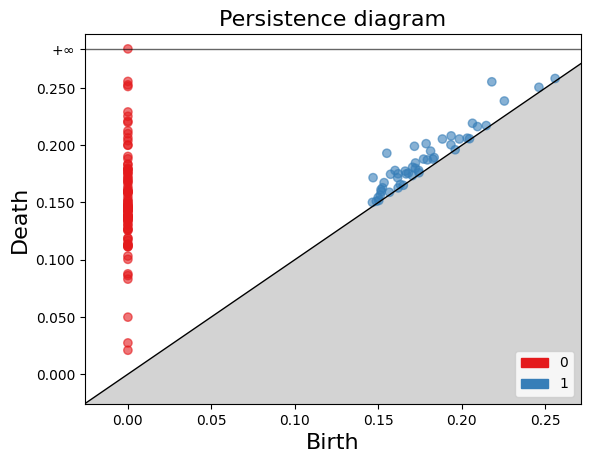

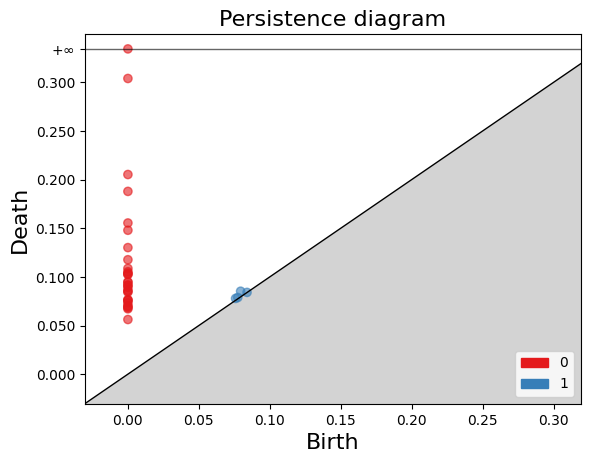

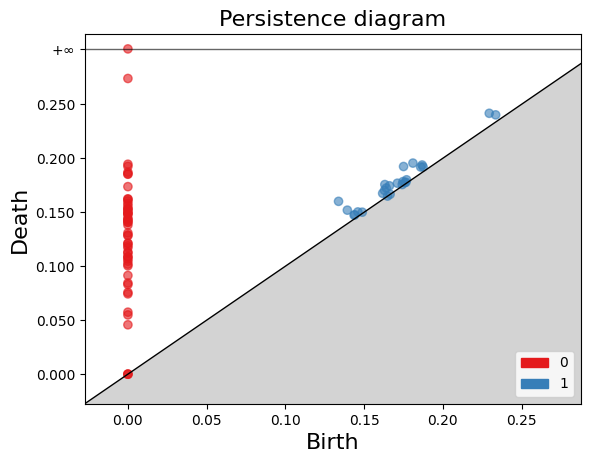

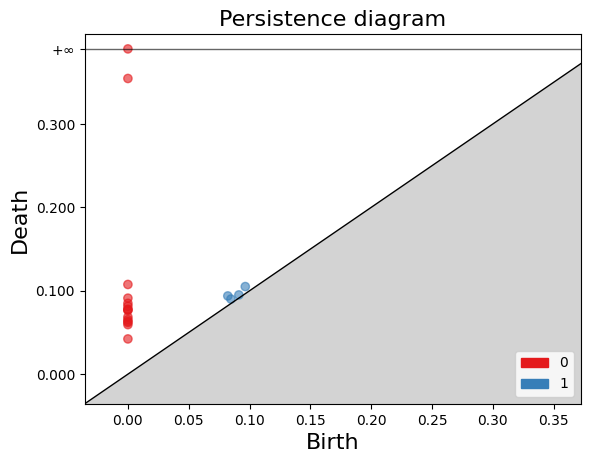

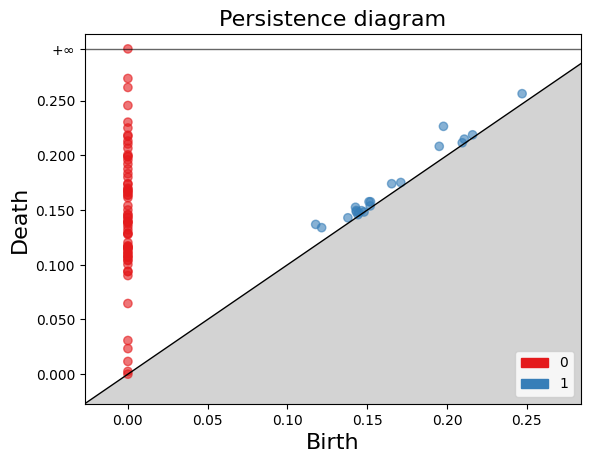

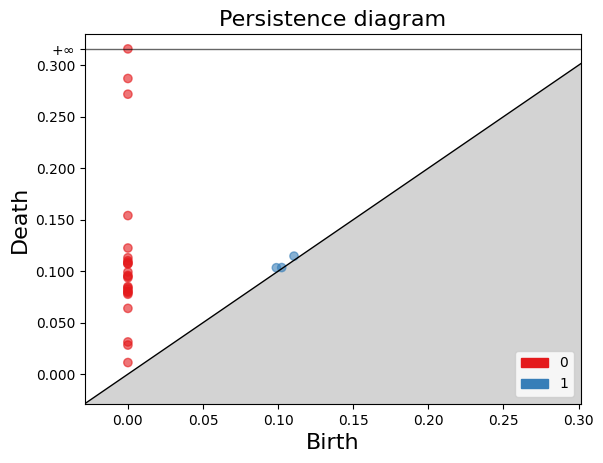

In [16]:

for h_num, (embs_sent, embs_edu) in enumerate(zip([embs_h1_sent, embs_h2_sent, embs_h3_sent], [embs_h1_edu, embs_h2_edu, embs_h3_edu])):
    for embs, type in zip([embs_edu, embs_sent], ['edu', 'sent']):
        distance_matrix = sklearn.metrics.pairwise_distances(embs, metric='cosine')
        rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=1.0)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        diag = simplex_tree.persistence(min_persistence=0)
        arr_0 = np.array([list(v[1]) for v in diag if v[0] == 0], dtype=object)
        arr_1 = np.array([list(v[1]) for v in diag if v[0] == 1], dtype=object)

        np.save('output/persistence/{}_{}_{}_0.npy'.format(model_name_type, h_num, type), arr_0)
        np.save('output/persistence/{}_{}_{}_1.npy'.format(model_name_type, h_num, type), arr_1)
        gudhi.plot_persistence_diagram(diag)
        plt.savefig('output/persistence/{}_{}_{}.png'.format(model_name_type, h_num, type))

# gudhi.plot_persistence_diagram(diag)
# plt.show()

In [29]:

distance_dict= {
    0: {},
    1: {}
}
for dim in range(2):
    for h_num in range(3):
        for  type_  in ['edu', 'sent']:
            filename_roberta = 'output/persistence/{}_{}_{}_{}.npy'.format('roberta', h_num, type_, dim)
            filename_roberta_ft = 'output/persistence/{}_{}_{}_{}.npy'.format('roberta_ft', h_num, type_, dim)

            arr_roberta = np.load(filename_roberta, allow_pickle=True)
            arr_roberta_ft = np.load(filename_roberta_ft, allow_pickle=True)

            dist = gudhi.bottleneck_distance(arr_roberta, arr_roberta_ft)

            distance_dict[dim][f'{h_num}_{type_}'] = dist

print(distance_dict[1])


{'0_edu': 0.02679947018623352, '0_sent': 0.009552091360092163, '1_edu': 0.020919620990753174, '1_sent': 0.011803001165390015, '2_edu': 0.017893612384796143, '2_sent': 0.005640000104904175}


In [39]:
# with open(f'output/scores_{model_name_type}_h1_edu.json', 'w') as f:
#     json.dump(scores_h1_edu, f)
# with open(f'output/scores_{model_name_type}_h1_sent.json', 'w') as f:
#     json.dump(scores_h1_sent, f)

# with open(f'output/scores_{model_name_type}_h2_edu.json', 'w') as f:
#     json.dump(scores_h2_edu, f)
# with open(f'output/scores_{model_name_type}_h2_sent.json', 'w') as f:
#     json.dump(scores_h2_sent, f)

with open(f'output/scores_{model_name_type}_h3_edu.json', 'w') as f:
    json.dump(scores_h3_edu, f)
with open(f'output/scores_{model_name_type}_h3_sent.json', 'w') as f:
    json.dump(scores_h3_sent, f)

In [61]:
sents = h2_ds[0]['sentence']
ref = h2_ds[0]['highlights']
embs = embs_h2_sent


In [57]:

from hierarchy_node import HierarchyNode
import numpy as np
import summarization

#references = [summary.strip().replace('\n', '')]

#embs = np.array(embs).reshape(-1, 1)
hierarchy = HierarchyNode(embs)
hierarchy.calculate_persistence()
adjacency = hierarchy.h_nodes_adj
n_leaves = np.min(list(adjacency.keys()))
n_nodes = np.max(list(adjacency.keys())) + 1
trimming_summary, trimmed, important = summarization.get_hierarchy_summary_ids(embs)

tup = summarization.get_hierarchy_summary(embs, sents)
candidates = summarization.get_all_salient_primary_pairs(tup[3], tup[1])
print(tup[5])
print(candidates)
#summary = ['.'.join(tup[5])]

()
[18, 17, 16, 21]


In [58]:
primary_pair_leaves = []
for cand in candidates:
    print(tup[1][cand])
    primary_pair_leaves.append(tup[1][cand][0])
    primary_pair_leaves.append(tup[1][cand][1])
for ppl in primary_pair_leaves:
    print(sents[ppl])


[2, 4]
[13, 14]
[1, 3]
[5, 9]
 Midway through a comment on cold weather, Frazier stops and apologies, reaching into the back of his suit jacket, only to find a wire hanger
 He paused mid-sentence to reach into the back of his suit, only to find a hanger that he forgot to take out when he put the jacket on 
 'I went to the gym today and the suit was fitting tight and I couldn't figure out why but I must have put it on to quick,' he said
 Frazier attempted to continue the weather, but he stopped to explain that he must have put his suit on too quickly after going to the gym 
 Steve Frazier was sitting at the news desk with two anchors when he realized his suit was fitting a bit tighter than usual
 Minneapolis weatherman Steve Frazier was sitting with the news anchors on live TV when he realized his suit was fitting a bit snug 
 The news anchors burst into laughter on live TV as Frazier sets the hanger on the desk, saying that he thought the suit was feeling tight because of a button
 But

In [62]:
rouge.compute(predictions=["Steve Frazier, a Minneapolis weatherman, was on live TV sitting at the news desk with two anchors. While attempting to continue the weather report, he realized his suit felt tight because he had left a coat hanger in it. He explained this when he noticed it while putting the jacket on before leaving the gym."], references=[ref])


{'rouge1': 0.3655913978494624,
 'rouge2': 0.04395604395604395,
 'rougeL': 0.21505376344086022,
 'rougeLsum': 0.25806451612903225}

In [64]:
rouge.compute(predictions=["Minneapolis weatherman Steve Frazier had a humorous moment on live TV when he realized he had left a hanger in his suit, causing it to feel tight. Midway through his weather report, he stopped to apologize and pulled out the hanger from his suit jacket, much to the amusement of his colleagues and viewers. Frazier initially thought the tightness was due to a button. He explained that he had rushed putting on the suit after leaving the gym. Despite attempts to continue, his laughter and explanations added to the hilarity of the situation."], references=[ref])

{'rouge1': 0.33587786259541985,
 'rouge2': 0.10852713178294573,
 'rougeL': 0.22900763358778628,
 'rougeLsum': 0.24427480916030533}

In [1]:
for s in tup[3]:
    print(s)
    adj = tup[1]
    print(adj)
    print(len(sents))
    print(sents[s])

NameError: name 'tup' is not defined